In [35]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

sys.path.append("../")
from utils.io import read_parameters
from src.plot_trajectories import plot_trajectories_per_file
from src.plot_trajectories import plot_trajectories_from_origin_per_file
from src.plot_trajectories import plot_trajectories_from_origin_per_condition
from src.plot_trajectories import normalize_speed

cmap = matplotlib.colormaps["seismic"]

In [36]:
# read parameters and key file

parameter_file  = "../local/parameters.yml"
parameters = read_parameters(parameter_file)       

key_file_path = parameters["key_file"]
key_file = pd.read_csv(key_file_path)

print("key file columns:", key_file.columns)
print("key file conditions:", key_file["condition"].unique())

key file columns: Index(['experimentID', 'filename', 'color', 'mosaic', 'treatment', 'condition',
       'date'],
      dtype='object')
key file conditions: ['mosaic_siCTRL_siCTRL' 'mosaic_siCTRL_siAlk1' 'mosaic_siCTRL_siSMAD4']


In [37]:
# create output folder

output_folder = parameters["output_folder"]
print("Output folder:", output_folder)

data_folder = output_folder + "/tracking_data/"

subfolder = "trajectory_plots"
if not os.path.exists(output_folder + "/" + subfolder):
    os.mkdir(output_folder + "/" + subfolder)

#tracking_data = pd.read_csv(data_folder + "tracking_data.csv") 


Output folder: /media/fjodor/Elephant/Dropbox/MDC_Projects/Olya_migration/mosaic/output_olya_mosaic_20240610/


In [38]:
# plot paramters

condition = 'mosaic_siCTRL_siAlk1'
color = 'red'
treatment = 'siAlk1'

number_of_tracks_per_condition = 1000

observation_time = parameters["observation_time"]
obs_time_length_frames = observation_time[1] - observation_time[0]
obs_time_length_hour = (observation_time[1] - observation_time[0])/parameters["frames_per_hour"]

min_speed = -10.0 # um/h
max_speed = 10.0 # um/h

max_x = 50.0 # um
max_y = 50.0 # um

sample 250 tracks per file
Available tracks: 1085
sampled 250 tracks for file tracking_data_siAlk1_red_230804_iCTRL_siAlk1.csv
Available tracks: 999
sampled 250 tracks for file tracking_data_siAlk1_red_230811_iCTRL_siAlk1.csv
Available tracks: 1085
sampled 250 tracks for file tracking_data_siAlk1_red_230817_iCTRL_siAlk1.csv
Available tracks: 1247
sampled 250 tracks for file tracking_data_siAlk1_red_230825_iCTRL_siAlk1.csv
sampled 1000 tracks in total
max velocity: %s um/h:  6.125  min velocity: %s um/h:  -8.25


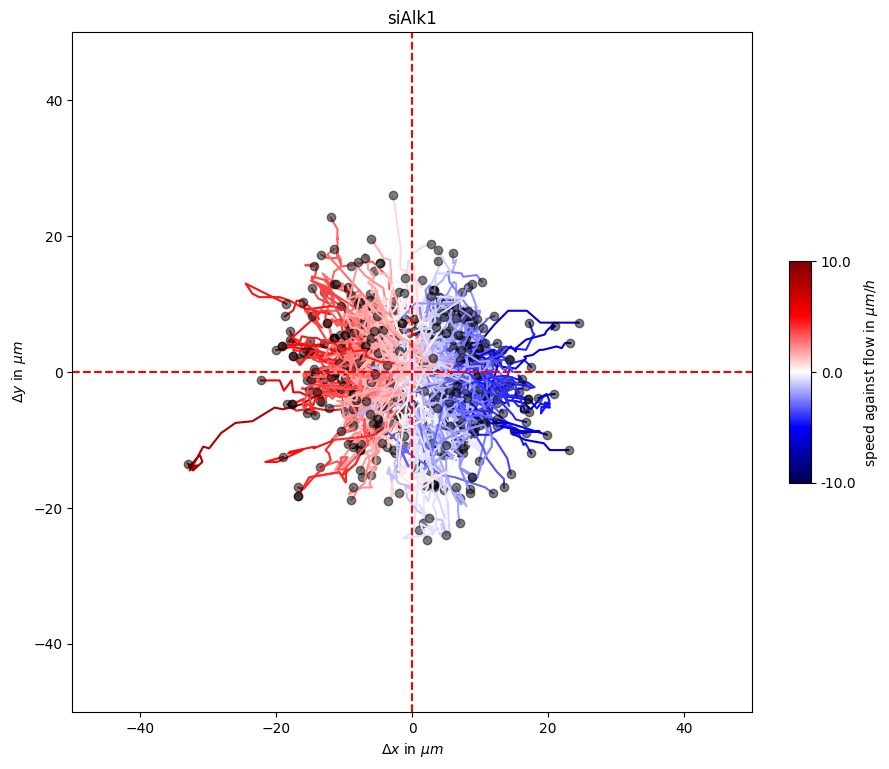

In [39]:
#key_select = key_file[key_file["condition"] == ]
#key_select = key_select[key_select["color"] == color]
key_select = key_file[key_file["treatment"] == treatment] 

number_of_tracks_per_file = int(number_of_tracks_per_condition/len(key_select.index))
print("sample %s tracks per file" % number_of_tracks_per_file)

track_counter = 0
center_x = 0
center_y = 0
max_vel = 0
min_vel = 0

fig, ax = plt.subplots(figsize=(9,9))

for index, row in key_select.iterrows():

    tracking_file = "tracking_data_%s_%s_%s.csv" % (treatment, row["color"], row["experimentID"])
                
    data = pd.read_csv(data_folder+ tracking_file, low_memory=False)

    observation_period_df = data[data["FRAME"] <= observation_time[1]]
    observation_period_df = observation_period_df[observation_period_df["FRAME"] >= observation_time[0]]

    trackID_list = np.array(observation_period_df["TRACK_ID"].unique())
    print("Available tracks: %s" % len(trackID_list))
    trackID_list = np.random.choice(trackID_list, number_of_tracks_per_file)

    print("sampled %s tracks for file %s" % (len(trackID_list),tracking_file))
    track_counter += len(trackID_list)

    center_per_file_x = 0.0
    center_per_file_y = 0.0
    total_dist_per_file = 0.0
                
    for track_id in trackID_list:
        single_track_df = observation_period_df[observation_period_df["TRACK_ID"] == track_id]

        end_x = np.array(single_track_df["ORIGIN_X"])[-1]
        end_y = np.array(single_track_df["ORIGIN_Y"])[-1]

        total_dist_per_file += np.sqrt(end_x**2 + end_y**2)

        center_x += end_x
        center_y += end_y

        center_per_file_x += end_x
        center_per_file_y += end_y

        rel_vel = normalize_speed(-end_x/obs_time_length_hour, min_speed, max_speed)

        if end_x/obs_time_length_hour > max_vel:
            max_vel = end_x/obs_time_length_hour
        if end_x/obs_time_length_hour < min_vel:
            min_vel = end_x/obs_time_length_hour

                    # ax.plot(single_track_df["ORIGIN_X"],single_track_df["ORIGIN_Y"], color = "#ff7f00")
                    # ax.plot([end_x],[end_y], color = "black", marker = "o")

                    # color by track id             
                    #ax.plot(single_track_df["ORIGIN_X"], single_track_df["ORIGIN_Y"])
                    #ax.plot([end_x], [end_y], marker="o")

                    # color by velocity   
        ax.plot(single_track_df["ORIGIN_X"],single_track_df["ORIGIN_Y"], color = cmap(rel_vel))
        ax.plot([end_x],[end_y], color = "black", marker = "o", alpha=0.5) 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, ax=ax, label='speed against flow in $\mu m/h$', aspect=10, fraction = 0.03)
cbar.set_ticks([0.0,0.5,1.0])
# Optionally, set tick labels if you want to customize them further
cbar.set_ticklabels([min_speed, 0.0, max_speed])


print("sampled %s tracks in total" % track_counter)
print("max velocity: %s um/h: ", max_vel, " min velocity: %s um/h: ", min_vel)

ax.set_xlim(-max_x,max_y)
ax.set_ylim(-max_x,max_y)
ax.axhline(0, color = "red", linestyle = "--")
ax.axvline(0, color = "red", linestyle = "--")
ax.set_title(treatment)
ax.set_xlabel("$\Delta x$ in $\mu m$")
ax.set_ylabel("$\Delta y$ in $\mu m$")
ax.set_aspect(1)
plt.tight_layout()

In [40]:
#single_condition_data = tracking_data[tracking_data["condition"] == condition]
#single_color_data = single_condition_data[single_condition_data["color"] == color]
#single_color_data = single_color_data[data["FRAME"] <= parameters["observation_period"][1]]
#ingle_color_data = single_color_data[data["FRAME"] >= parameters["observation_period"][0]]

In [41]:
# plot_trajectories_from_origin_per_condition(parameters, key_file, subfolder = "tracking_data", number_of_tracks_per_condition = parameters["number_of_cells_per_condition"])